# ДЗ 04. ML для бизнеса

1. Прочитайте базу my_PJME_MW.csv и сделайте ее перерасчет (ресемплинг) в представление по неделям.

2. Постройте модель предсказания 4-й точки от текущей (h = 4), используя результаты автокорреляционного анализа из предшествующих уроков .

3. Постройте модель предсказания 1-й точки от текущей (h = 1), используя результаты автокорреляционного анализа из предшествующих уроков.

4. Примените авторекурсию и сравните результат в 4-й точке путем прямого моделирования и путем рекурсивного моделирования на длине выборки из 4-х точек.

5. Оцените рост ошибки прогнозирования рекурсивной модели в интервалах от 1-й до 10-й, от 10-й до 20-й, от 20-й до 30-й, .. .10*i-й до (i+1)*10 -й,... ,от 90 до 100-й точках (используйте осреднение по десяткам точек)

6. Сделайте вывод о том, как изменилось поведение ошибки предсказания ряда.

In [64]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import os

## Задание 1

Прочитайте базу my_PJME_MW.csv и сделайте ее перерасчет (ресемплинг) в представление по неделям.

In [65]:
pwd

'/Users/artem/Movies/ML_buisness_course/hw/lesson04'

In [66]:
df = pd.read_csv('../../lesson4/my_PJME_MW.csv', index_col = [0], parse_dates = [0])#/Users/artem/Movies/ML_buisness_course/lesson4/my_PJME_MW.csv

Делаем ресемплинг и подчищаем датасет (удаляём столбец с часом, NaN-строки)

In [67]:
df_week = df.copy()
df_week = df_week.resample('W').mean()
df_week.dropna()
df_week = df_week.drop(columns=['hour'])
df_week.head()

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,
2002-01-06,32392.160839,2002.0,1.000000,3.517483,1.0,3.517483,1.0,3.517483,0.160839,0.000000,0.167832
2002-01-13,31487.386905,2002.0,1.000000,10.000000,1.0,10.000000,2.0,3.000000,0.000000,0.000000,0.000000
2002-01-20,31452.880952,2002.0,1.000000,17.000000,1.0,17.000000,3.0,3.000000,0.000000,0.142857,0.000000
2002-01-27,30141.529762,2002.0,1.000000,24.000000,1.0,24.000000,4.0,3.000000,0.142857,0.000000,0.142857
2002-02-03,29196.488095,2002.0,1.428571,17.714286,1.0,31.000000,5.0,3.000000,0.000000,0.000000,0.000000


Выводим на график:

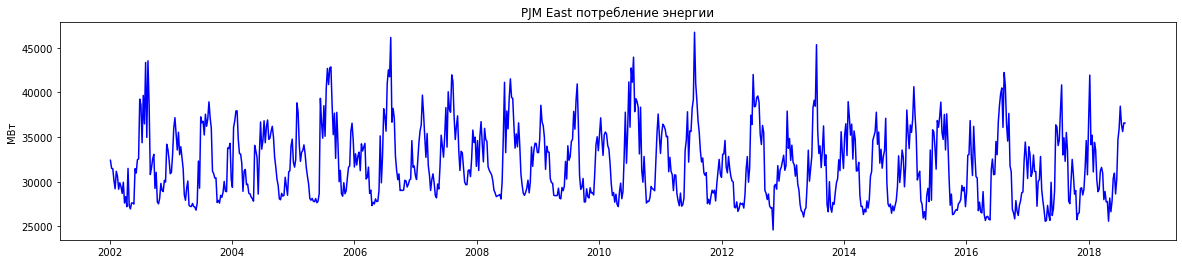

In [68]:
plt.figure(figsize =(20,4))
plt.plot( df_week.index, df_week['PJME_MW'], 'b' )
plt.title('PJM East потребление энергии' )
plt.ylabel ( 'МВт' )
plt.show()

## Задание 2

Постройте модель предсказания 4-й точки от текущей (h = 4), используя результаты автокорреляционного анализа из предшествующих уроков .

Постройте модель предсказания 1-й точки от текущей (h = 1), используя результаты автокорреляционного анализа из предшествующих уроков.

In [89]:
h = 4

### Создаём признаки

In [69]:
# стандартизация данных
scl=StandardScaler()
X = df_week.iloc[:,:-1].values
Xscale = scl.fit_transform(X)

In [70]:
from sklearn.decomposition import PCA

# создание двух признаков pca1, pca2
pca = PCA(n_components=2, svd_solver='full')
Xpca=pca.fit_transform(Xscale[:,1:])
df_week['pca1']=Xpca[:,0]
df_week['pca2']=Xpca[:,1]

In [71]:
# разница 1го порядка
first_diff =np.array(df_week.iloc[1:,0].values - df_week.iloc[:-1,0].values).astype('float32') 
df_week['diff1'] = 0
df_week['diff1'] =  df_week['diff1'].astype('float') 
df_week['diff1'].values[1:] = first_diff

In [72]:
# скользящее среднее по 4м неделям (1 месяц)
df_week['4w']=df_week['PJME_MW'].rolling(window=4).mean()

In [73]:
# EMA экспоненциальное скользящее среднее
def exponential_smoothing(series, alpha):
    result = [series[0]] 
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

df_week['exp_0_05'] = exponential_smoothing(df_week['PJME_MW'], 0.05)

Визуализиуем новые признаки:

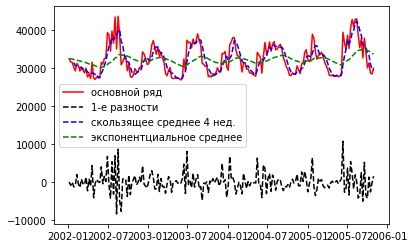

In [74]:
N100=200
plt.plot(df_week.index[:N100],df_week['PJME_MW'][:N100],'r',label ='основной ряд')
plt.plot(df_week.index[:N100],df_week['diff1'][:N100],'--k',label ='1-е разности')
plt.plot(df_week.index[:N100],df_week['4w'][:N100],'--b',label ='скользящее среднее 4 нед.')
plt.plot(df_week.index[:N100],df_week['exp_0_05'][:N100],'--g',label ='экспонентциальное среднее')
plt.legend()
plt.show()

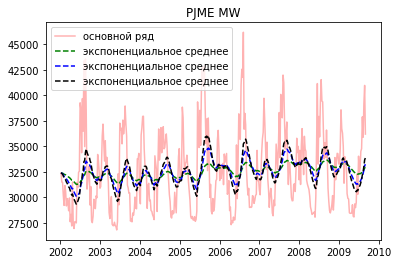

In [75]:
# экспоненциальные скользящие средние
df_week['exp_0_02'] = exponential_smoothing(df_week['PJME_MW'], 0.02)
df_week['exp_0_08'] = exponential_smoothing(df_week['PJME_MW'], 0.08)

N100=400
plt.plot(df_week.index[:N100],df_week['PJME_MW'][:N100],'r',label ='основной ряд',alpha=0.3)
plt.plot(df_week.index[:N100],df_week['exp_0_02'][:N100],'--g',label ='экспоненциальное среднее')
plt.plot(df_week.index[:N100],df_week['exp_0_05'][:N100],'--b',label ='экспоненциальное среднее')
plt.plot(df_week.index[:N100],df_week['exp_0_08'][:N100],'--k',label ='экспоненциальное среднее')
plt.legend()
plt.title('PJME MW')
plt.show()

In [77]:
df_week = df_week.dropna()

Добавим истории длиной p в признаках автокорреляции

In [80]:
p = 4
for i in range(p):
    df_week['t'+str(p-i)]=0
    df_week['t'+str(p-i)].values[p:] = df_week['PJME_MW'].values[i:-(p)+i]

добавляем первые разности на глубину p

In [81]:
p = 4
for i in range(p):
    df_week['d'+str(p-i)]=0
    df_week['d'+str(p-i)].values[p:] = df_week['diff1'].values[i:-(p)+i]

In [84]:
# Итоговая система признаков
pd.options.display.max_columns = None
df_week

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday,pca1,pca2,diff1,4w,exp_0_05,exp_0_02,exp_0_08,t4,t3,t2,t1,d4,d3,d2,d1
Date,,,,,,,,,,,,,,,,,,,,,,,,,,
2002-01-27,30141.529762,2002.0,1.000000,24.000000,1.0,24.000000,4.0,3.000000,0.142857,0.000000,0.142857,-2.756246,-1.684856,-1311.351196,31368.489615,32194.185567,32311.359434,32081.715301,0,0,0,0,0,0,0,0
2002-02-03,29196.488095,2002.0,1.428571,17.714286,1.0,31.000000,5.0,3.000000,0.000000,0.000000,0.000000,-2.851559,0.194201,-945.041687,30569.571429,32044.300693,32249.062007,31850.897124,0,0,0,0,0,0,0,0
2002-02-10,31150.517857,2002.0,2.000000,7.000000,1.0,38.000000,6.0,3.000000,0.000000,0.000000,0.000000,-2.755410,0.371114,1954.029785,30485.354167,31999.611551,32227.091124,31794.866783,0,0,0,0,0,0,0,0
2002-02-17,30616.565476,2002.0,2.000000,14.000000,1.0,45.000000,7.0,3.000000,0.000000,0.142857,0.000000,-2.400228,-1.429823,-533.952393,30276.275298,31930.459248,32194.880611,31700.602678,0,0,0,0,0,0,0,0
2002-02-24,29144.130952,2002.0,2.000000,21.000000,1.0,52.000000,8.0,3.000000,0.142857,0.000000,0.142857,-2.357317,-1.586482,-1472.434570,30026.925595,31791.142833,32133.865618,31496.084940,30141,29196,31150,30616,-1311,-945,1954,-533
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-07-08,38459.982143,2018.0,7.000000,5.000000,3.0,186.000000,27.0,3.000000,0.142857,0.142857,0.142857,0.627308,-2.536114,2548.142822,34850.102679,31029.513277,30991.508945,31223.895665,28615,30316,34711,35911,-2330,1701,4394,1200
2018-07-15,36420.035714,2018.0,7.000000,12.000000,3.0,193.000000,28.0,3.000000,0.000000,0.000000,0.000000,0.284110,0.846910,-2039.946411,36375.876488,31299.039399,31100.079481,31639.586869,30316,34711,35911,38459,1701,4394,1200,2548
2018-07-22,35612.095238,2018.0,7.000000,19.000000,3.0,200.000000,29.0,3.000000,0.000000,0.000000,0.000000,0.386630,0.753033,-807.940491,36600.988095,31514.692191,31190.319796,31957.387539,34711,35911,38459,36420,4394,1200,2548,-2039


### Выделение существенных признаков

In [90]:
scl_target=StandardScaler() 
# p = 4
h=4
target = df_week['PJME_MW'].values[h+p:].reshape((df_week.shape[0]-h-p,1))
y = scl_target.fit_transform(target)
y.shape

(855, 1)

In [91]:
scl_x=StandardScaler() 

X = df_week.iloc[p:-h,:].values
X = scl_x.fit_transform(X.astype('float64'))
X.shape

(855, 26)

In [92]:
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import SelectFromModel

from sklearn.ensemble import GradientBoostingRegressor

from sklearn.feature_selection import f_regression, mutual_info_regression

f_test, _ = f_regression(X, y.ravel())
f_test /= np.max(f_test)
for i in range(X.shape[1]):
    print("F-test={:.2f},  I={}".format(f_test[i],i))

F-test=1.00,  I=0
F-test=0.05,  I=1
F-test=0.02,  I=2
F-test=0.00,  I=3
F-test=0.02,  I=4
F-test=0.02,  I=5
F-test=0.02,  I=6
F-test=0.01,  I=7
F-test=0.07,  I=8
F-test=0.06,  I=9
F-test=0.07,  I=10
F-test=0.03,  I=11
F-test=0.09,  I=12
F-test=0.18,  I=13
F-test=0.29,  I=14
F-test=0.13,  I=15
F-test=0.04,  I=16
F-test=0.11,  I=17
F-test=0.09,  I=18
F-test=0.00,  I=19
F-test=0.11,  I=20
F-test=0.43,  I=21
F-test=0.20,  I=22
F-test=0.23,  I=23
F-test=0.26,  I=24
F-test=0.23,  I=25


Применим автоматизацию выбора через SelectKBest c выделением 5 лучших признаков.

In [93]:
sfk =SelectKBest(f_regression, k=5)
X_new1 =sfk.fit_transform(X, y.ravel())
X_new1.shape

(855, 5)

In [96]:
column_names = df_week.columns[sfk.get_support()]
column_names

Index(['PJME_MW', '4w', 't1', 'd3', 'd2'], dtype='object')

Лучшее множество признаков отделено в X_new1

### Разделение данных на тестовые и тренировочные 

In [97]:
# сделаем функцию разбиения на трейн и тест выборки
def split_data( data, split_date ):
    return data.loc[data.index.get_level_values('Date') <= split_date].copy(), \
           data.loc[data.index.get_level_values('Date') >  split_date].copy()

назначим датой разделения 1/06/2016

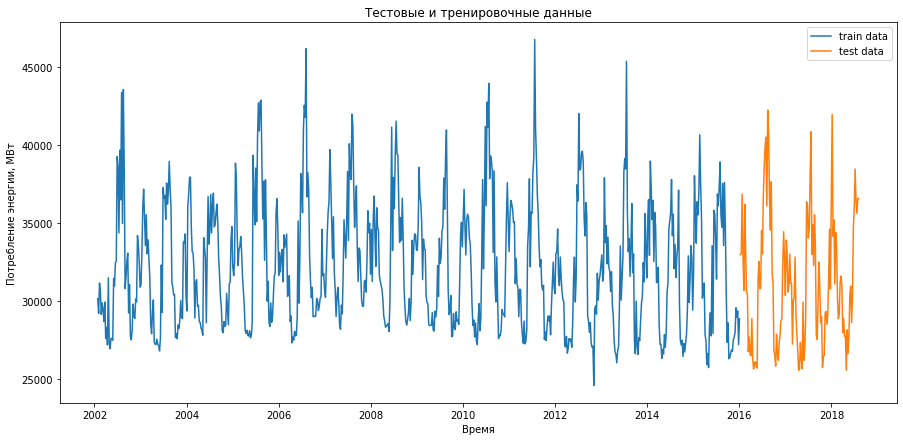

In [98]:
train, test = split_data(df_week, '01-06-2016')

plt.figure( figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(train.index.get_level_values('Date'),train['PJME_MW'], label='train data' )
plt.plot(test.index.get_level_values('Date'),test['PJME_MW'], label='test data')
plt.title( 'Тестовые и тренировочные данные' )
plt.legend()
plt.show()

In [100]:
X_train =X_new1[:train.shape[0],:]
y_train =y[:train.shape[0],0]
X_test =X_new1[train.shape[0]:,:]
y_test =y[train.shape[0]:,0]

In [109]:
X_new1

array([[-0.73322386, -0.57380238, -0.36268314, -0.36679175,  0.7545429 ],
       [-0.55167597, -0.52636078, -0.73187441,  0.75818634, -0.20899736],
       [-0.65889477, -0.64696098, -0.55003767, -0.20691215, -0.57279483],
       ...,
       [ 0.66117218, -0.25765547, -0.43792592,  0.21839864, -0.90521041],
       [ 0.9617623 ,  0.09267606,  0.66438089, -0.9042511 ,  0.65652292],
       [ 1.59994979,  0.78715616,  0.96535204,  0.66000784,  1.69987391]])

### Строим Модель

In [105]:
from sklearn.ensemble import GradientBoostingRegressor

In [111]:
model_g = GradientBoostingRegressor(max_depth=5, random_state=0, n_estimators=100)

In [112]:
model_g.fit( X_train, y_train ) # 

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto', random_state=0,
                          subsample=1.0, tol=0.0001, validation_fraction=0.1,
                          verbose=0, warm_start=False)

In [114]:
y_test_pred_g = model_g.predict(X_test)

In [159]:
hs = [1,4]
h_list = []
for h in hs:
    X_train_b = train.iloc[:-h,:]
    y_train_b = train[df.columns[0]].values[h:]
    X_test_b = test.iloc[:-h,:]
    y_test_b = test[df.columns[0]].values[h:]

    model_gb.fit( X_train_b, y_train_b ) 
    X_test_pred_gb = model_gb.predict(X_test_b)
    
    er_g_ = mean_absolute_percentage_error(y_true=y_test_b, y_pred=X_test_pred_gb)
    
    item = {'h_value':h, 'MAPE':er_g_}
    h_list.append(item)
    print(item)

KeyError: 'Time'

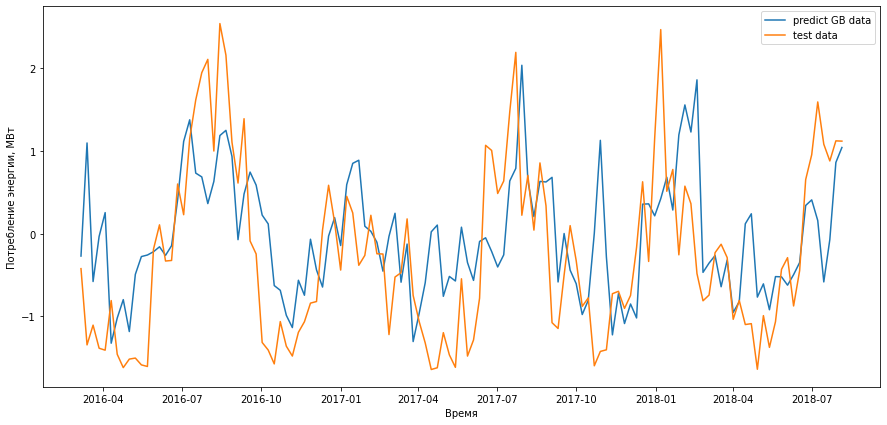

In [115]:
plt.figure( figsize=( 15, 7 ))

plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(test.index[h+p:],y_test_pred_g, label='predict GB data' )
plt.plot(test.index[h+p:],y_test, label='test data')

plt.legend()
plt.show()

**Оценки для сравнения моделей**

Оценим промах модели, используя метрики, которые можно применять для оценки регрессий https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics:
- средне-квадратичное отклонение
- среднюю абсолютную ошибку
- коэфиициент детерминации 

In [117]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [119]:
er_s = mean_squared_error(y_true=y_test, y_pred=y_test_pred_g) 
er_a = mean_absolute_error(y_true=y_test, y_pred=y_test_pred_g) 
er_r2 = r2_score(y_true=y_test, y_pred=y_test_pred_g)

print('ошибка mse :  ', er_s,'\nошибка mae  :  ', er_a,'\nоценка R2 :  ', er_r2)

ошибка mse :   0.8256079908662638 
ошибка mae  :   0.7110325881689589 
оценка R2 :   0.22632682614773436


In [142]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [143]:
er_g = mean_absolute_percentage_error(y_true=scl_target.inverse_transform( y_test),y_pred = scl_target.inverse_transform( y_test_pred_g))

print('ошибка градиентного бустинга MAPE :  ', er_g,'%')

ошибка градиентного бустинга MAPE :   9.38776664412367 %


### Задание 2

т.к. третье задание (предсказание на 1 период вперёд мы уже выполнили), сейчас выполняем предсказание 4й точки

### Использование модели для предсказания n*h моментов времени

In [153]:
n = 4

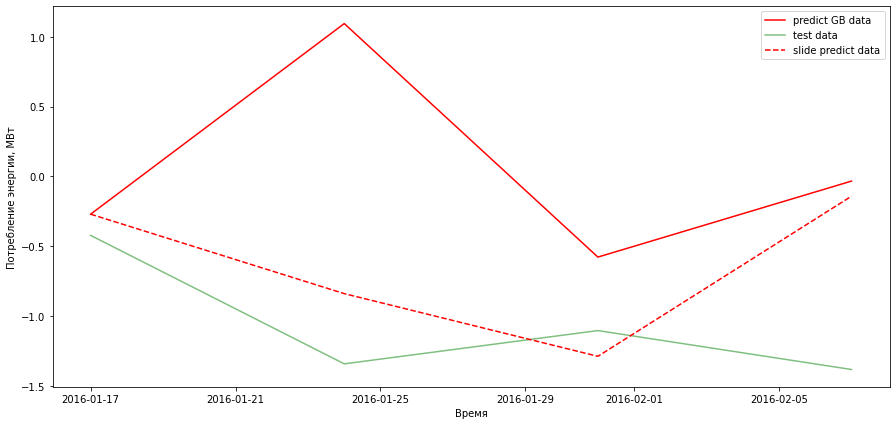

In [156]:
#['PJME_MW', '4w', 't1', 'd3', 'd2']
X_test_100 = X_test.copy()
y_test_100 = y_test_pred_g.copy()
N10 = n
for i in range(N10):
    y_test_100[i] = model_g.predict(X_test_100[i,:].reshape((1,5)))
    
    # заполняем вектор для прогноза следующей точки
    X_test_100[i+1,0] = y_test_100[i]
#     X_test_100[i+1,1] = 0#y_test_100[i]
#     X_test_100[i+1,2] = 0#y_test_100[i]
#     X_test_100[i+1,3] = 0#y_test_100[i]
#     X_test_100[i+1,4] = 0#y_test_100[i]
    
plt.figure( figsize=( 15, 7 ))


plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(test.index[1:N10+1],y_test_pred_g[:N10], 'r',label='predict GB data' )
plt.plot(test.index[1:N10+1],y_test[:N10], 'g',label='test data', alpha=0.5)
plt.plot(test.index[1:N10+1],y_test_100[:N10], '--r',label='slide predict data')

plt.legend()
plt.show()    

In [150]:
er_g = mean_absolute_percentage_error(y_true=scl_target.inverse_transform( y_test[:N10]),y_pred = scl_target.inverse_transform( y_test_100[:N10]))
print('ошибка градиентного бустинга MAPE :  ', er_g,'%')

ошибка градиентного бустинга MAPE :   4.630203479424019 %
